# Data

In [1]:
import squidpy as sq
import numpy as np
import pandas as pd
import numba.types as nt

import matplotlib.pyplot as plt

# pip install git+https://github.com/h2oai/datatable.git
import datatable

import os
import csv

In [2]:
meta = datatable.fread("exported_data/sim.csv")
meta = meta.to_pandas().set_index('C0')
meta.head()

,x,y,celltypes
C0,,,
cell1,531.017326,256.530309,A
cell2,744.247799,255.383047,D
cell3,1145.706727,1555.464671,D
cell4,1816.415580,840.300727,D
cell5,403.363862,1431.803866,A


In [3]:
from anndata import AnnData
from numpy.random import default_rng
rng = default_rng(42)

counts = rng.integers(0, 15, size=(meta.shape[0], 50))
counts.shape

(8000, 50)

In [4]:
adata = AnnData(counts, obsm={"spatial": np.array(meta[["x", "y"]], dtype=float)})

In [5]:
adata.obs = meta

/Users/rafaeldossantospeixoto/anaconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


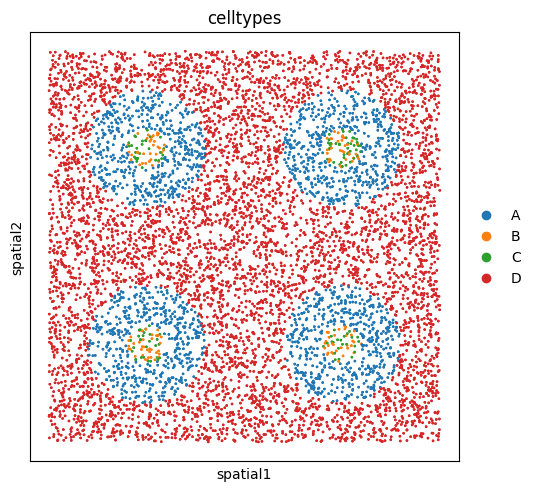

In [6]:
sq.pl.spatial_scatter(
        adata,
        shape = None,
        color = "celltypes",
        size=3
)

# Source

In [9]:
"""Functions for point patterns spatial statistics."""

from __future__ import annotations

from itertools import chain
from typing import (
    TYPE_CHECKING,
    Any,
    Dict,
    Iterable,
    Literal,  # < 3.8
    Sequence,
    Union,  # noqa: F401
)

import numba.types as nt
import numpy as np
import pandas as pd
from anndata import AnnData
from numba import njit
from numpy.random import default_rng
from scanpy import logging as logg
from scanpy.get import _get_obs_rep
from scanpy.metrics._gearys_c import _gearys_c
from scanpy.metrics._morans_i import _morans_i
from scipy import stats
from scipy.sparse import spmatrix
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
# from spatialdata import SpatialData
from statsmodels.stats.multitest import multipletests

from squidpy._constants._constants import SpatialAutocorr
from squidpy._constants._pkg_constants import Key
from squidpy._docs import d, inject_docs
from squidpy._utils import NDArrayA, Signal, SigQueue, _get_n_cores, parallelize
from squidpy.gr._utils import (
    _assert_categorical_obs,
    _assert_connectivity_key,
    _assert_non_empty_sequence,
    _assert_positive,
    _assert_spatial_basis,
    _save_data,
)

__all__ = ["spatial_autocorr", "co_occurrence"]


it = nt.int32
ft = nt.float32
tt = nt.UniTuple
ip = np.int32
fp = np.float32



@njit(
    ft[:, :, :](tt(it[:], 2), ft[:, :], it[:], ft[:]),
    parallel=False,
    fastmath=True,
)
def _occur_count(
    clust: tuple[NDArrayA, NDArrayA],
    pw_dist: NDArrayA,
    labs_unique: NDArrayA,
    interval: NDArrayA,
) -> NDArrayA:
    num = labs_unique.shape[0]
    out = np.zeros((num, num, interval.shape[0] - 1), dtype=ft)

    for idx in range(interval.shape[0] - 1):
        co_occur = np.zeros((num, num), dtype=ft)
        probs_con = np.zeros((num, num), dtype=ft)

        thres_min = interval[idx]
        thres_max = interval[idx + 1]
        clust_x, clust_y = clust

        idx_x, idx_y = np.nonzero((pw_dist <= thres_max) & (pw_dist > thres_min))
        x = clust_x[idx_x]
        y = clust_y[idx_y]
        for i, j in zip(x, y):
            co_occur[i, j] += 1

        probs_matrix = co_occur / np.sum(co_occur)
        probs = np.sum(probs_matrix, axis=1)

        for c in labs_unique:
            probs_conditional = co_occur[c] / np.sum(co_occur[c])
            probs_con[c, :] = probs_conditional / probs

        out[:, :, idx] = probs_con

    return out


def _co_occurrence_helper(
    idx_splits: Iterable[tuple[int, int]],
    spatial_splits: Sequence[NDArrayA],
    labs_splits: Sequence[NDArrayA],
    labs_unique: NDArrayA,
    interval: NDArrayA,
    queue: SigQueue | None = None,
) -> pd.DataFrame:
    out_lst = []
    for t in idx_splits:
        idx_x, idx_y = t
        labs_x = labs_splits[idx_x]
        labs_y = labs_splits[idx_y]
        dist = pairwise_distances(spatial_splits[idx_x], spatial_splits[idx_y])

        out = _occur_count((labs_x, labs_y), dist, labs_unique, interval)
        out_lst.append(out)

        if queue is not None:
            queue.put(Signal.UPDATE)

    if queue is not None:
        queue.put(Signal.FINISH)

    return out_lst



# [docs]
# @d.dedent
def co_occurrence(
    adata: AnnData | SpatialData,
    cluster_key: str,
    spatial_key: str = Key.obsm.spatial,
    interval: int | NDArrayA = 50,
    copy: bool = False,
    n_splits: int | None = None,
    n_jobs: int | None = None,
    backend: str = "loky",
    show_progress_bar: bool = True,
) -> tuple[NDArrayA, NDArrayA] | None:
    
    # if isinstance(adata, SpatialData):
    #     adata = adata.table
    # _assert_categorical_obs(adata, key=cluster_key)
    _assert_spatial_basis(adata, key=spatial_key)

    spatial = adata.obsm[spatial_key].astype(fp)
    original_clust = adata.obs[cluster_key]

    # annotate cluster idx
    clust_map = {v: i for i, v in enumerate(original_clust.cat.categories.values)}
    labs = np.array([clust_map[c] for c in original_clust], dtype=ip)
    labs_unique = np.array(list(clust_map.values()), dtype=ip)

    # create intervals thresholds
    if isinstance(interval, int):
        thresh_min, thresh_max = _find_min_max(spatial)
        interval = np.linspace(thresh_min, thresh_max, num=interval, dtype=fp)
    else:
        interval = np.array(sorted(interval), dtype=fp, copy=True)
    if len(interval) <= 1:
        raise ValueError(f"Expected interval to be of length `>= 2`, found `{len(interval)}`.")

    n_obs = spatial.shape[0]
    if n_splits is None:
        size_arr = (n_obs**2 * spatial.itemsize) / 1024 / 1024  # calc expected mem usage
        if size_arr > 2000:
            n_splits = 1
            while 2048 < (n_obs / n_splits):
                n_splits += 1
            logg.warning(
                f"`n_splits` was automatically set to `{n_splits}` to "
                f"prevent `{n_obs}x{n_obs}` distance matrix from being created"
            )
        else:
            n_splits = 1
    n_splits = max(min(n_splits, n_obs), 1)

    # split array and labels
    spatial_splits = tuple(s for s in np.array_split(spatial, n_splits, axis=0) if len(s))  # type: ignore[arg-type]
    labs_splits = tuple(s for s in np.array_split(labs, n_splits, axis=0) if len(s))  # type: ignore[arg-type]
    # create idx array including unique combinations and self-comparison
    x, y = np.triu_indices_from(np.empty((n_splits, n_splits)))  # type: ignore[arg-type]
    idx_splits = list(zip(x, y))

    n_jobs = _get_n_cores(n_jobs)
    start = logg.info(
        f"Calculating co-occurrence probabilities for `{len(interval)}` intervals "
        f"`{len(idx_splits)}` split combinations using `{n_jobs}` core(s)"
    )

    out_lst = parallelize(
        _co_occurrence_helper,
        collection=idx_splits,
        extractor=chain.from_iterable,
        n_jobs=n_jobs,
        backend=backend,
        show_progress_bar=show_progress_bar,
    )(
        spatial_splits=spatial_splits,
        labs_splits=labs_splits,
        labs_unique=labs_unique,
        interval=interval,
    )
    out = list(out_lst)[0] if len(idx_splits) == 1 else sum(list(out_lst)) / len(idx_splits)

    if copy:
        logg.info("Finish", time=start)
        return out, interval

    _save_data(
        adata, attr="uns", key=Key.uns.co_occurrence(cluster_key), data={"occ": out, "interval": interval}, time=start
    )



def _find_min_max(spatial: NDArrayA) -> tuple[float, float]:
    coord_sum = np.sum(spatial, axis=1)
    min_idx, min_idx2 = np.argpartition(coord_sum, 2)[:2]
    max_idx = np.argmax(coord_sum)
    # fmt: off
    thres_max = pairwise_distances(spatial[min_idx, :].reshape(1, -1), spatial[max_idx, :].reshape(1, -1))[0, 0] / 2.0
    thres_min = pairwise_distances(spatial[min_idx, :].reshape(1, -1), spatial[min_idx2, :].reshape(1, -1))[0, 0]
    # fmt: on

    return thres_min.astype(fp), thres_max.astype(fp)


# Running

In [10]:
co_occurrence(adata, cluster_key = "celltypes")

100%|██████████| 1/1 [00:10<00:00, 10.21s/]
